## Code start

In [ ]:
import glob
import pandas as pd
import os


def read_data(abs_path, subdir_name, x_axis_col_name="iu_var"):
    fpaths = glob.glob(os.path.join(abs_path, subdir_name, "*", "FP_FN_count_full.csv"))

    all_dfs = []
    print(f"Reading data from {len(fpaths)} files")
    for fpath in fpaths:
        df = pd.read_csv(fpath)
        # extract the number after the 8th _ in the params col
        df[x_axis_col_name] = df["params"].apply(
            lambda x: x.split("_")[1]
        )  # since the file name has the form: SymNotePol_00
        all_dfs.append(df)

    all_df = pd.concat(all_dfs)
    all_df[x_axis_col_name] = all_df[x_axis_col_name].astype(int)
    all_df = all_df.sort_values(by=x_axis_col_name)
    return all_df

In [5]:
# Get iu_var of users

abs_path = "/N/project/community_notes_manip/communitynotes/synthetic_data/2025-07-10_results/raw_output"
sym = read_data(abs_path, subdir_name="SymNotePol", x_axis_col_name="polarization")

Reading data from 11 files


In [6]:
intermediate_dir = "fp_raw_count"
if not os.path.exists(intermediate_dir):
    os.makedirs(intermediate_dir)
sym.to_csv(os.path.join(intermediate_dir, "SymNotePol.csv"), index=False)

In [7]:
sym.tail()

,params,run_result_dir,n_H,n_U,n_h,n_u,p_u_H,p_h_U,p_H_u,p_U_h,polarization
19,SymNotePol_10,/N/project/community_notes_manip/communitynote...,1815,13640,157,15298,0.974105,0.008065,0.115571,0.700637,10
20,SymNotePol_10,/N/project/community_notes_manip/communitynote...,1817,13638,157,15298,0.973583,0.007992,0.115636,0.694268,10
21,SymNotePol_10,/N/project/community_notes_manip/communitynote...,1746,13709,157,15298,0.973654,0.008097,0.111126,0.707006,10
23,SymNotePol_10,/N/project/community_notes_manip/communitynote...,1792,13663,157,15298,0.973214,0.007978,0.114002,0.694268,10
24,SymNotePol_10,/N/project/community_notes_manip/communitynote...,1958,13497,157,15298,0.974464,0.007928,0.124722,0.681529,10


In [ ]:
def linear_mapping(x, x_min, x_max, y_min, y_max):
    # map x to y in a scale from y_min to y_max
    return (x - x_min) / (x_max - x_min) * (y_max - y_min) + y_min


linear_mapping(0.5, 0, 1, 0.04, 0.09)

0.065

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.style.use("stylesheet.mplstyle")
PALETTE = [
    "#209B8A",  # teal
    "#550F6B",  # purple
    "#3863AC",  # blue
    "#BC3684",  # pink
]
names = {
    "p_u_H": "False discovery rate P(u|H)",
    "p_U_h": "Supression rate P(U|h)",
    "p_H_u": "False positive rate P(H|u)",
    "p_h_U": "False negative rate P(h|U)",
}


def plot_fp_fn(
    df,
    x_axis_col_name="iu_var",
    title="",
    xlabel="",
    ylabel="",
    legend=True,
    legend_loc="upper right",
    save_path="",
):
    if not (
        "p_u_H" in df.columns
        and "p_h_U" in df.columns
        and "p_H_u" in df.columns
        and "p_U_h" in df.columns
    ):
        raise ValueError(
            "df must contain one of the following columns: 'p_u_H', 'p_h_U', 'p_H_u', 'p_U_h'"
        )

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_xlim(0, 1)

    def plot_curve(df, x, y, color, label):
        curve_ax = sns.boxplot(data=df, x=x, y=y, whis=np.inf, ax=ax, color=color)
        curve_ax = sns.stripplot(
            data=df,
            x=x,
            y=y,
            dodge=True,
            size=4,
            alpha=0.5,
            ax=ax,
            color=color,
        )
        return curve_ax

    # create a legend for the colors
    # legend_elements = []

    def linear_mapping(x, x_min, x_max, y_min, y_max):
        # map x to y in a scale from y_min to y_max
        return (x - x_min) / (x_max - x_min) * (y_max - y_min) + y_min

    for i, col in enumerate(names.keys()):
        plot_curve(df, x=x_axis_col_name, y=col, color=PALETTE[i], label=names[col])

        y_avg = df[col].mean()
        y_min, y_max = ax.get_ylim()
        text_y_coor = linear_mapping(y_avg, 0, 1, y_min, y_max) + 0.06
        if col == "p_H_u":
            text_y_coor = linear_mapping(y_avg, 0, 1, y_min, y_max) - 0.02

        if col == "p_h_U":
            text_y_coor = linear_mapping(y_avg, 0, 1, y_min, y_max) + 0.02

        x_min, x_max = ax.get_xlim()
        text_x_coor = (x_max - x_min) / 2 + 2

        plt.text(
            text_x_coor,
            text_y_coor,
            names[col],
            color=PALETTE[i],
            fontsize=10,
            ha="left",
            va="bottom",
            fontweight="bold",
        )

        # legend_elements.append(
        #     Line2D([0], [0], color=PALETTE[i], label=names[col], lw=4)
        # )

    # remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ax.legend(handles=legend_elements, loc="best")
    # set xticks to be less dense
    ax.set_xticks(ax.get_xticks()[::2])
    plt.xlabel(xlabel)
    plt.ylabel("")
    plt.title(title, fontsize=12)  # add padding between title and plot
    plt.tight_layout()
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(f"{save_path}/{title}.png", dpi=300)

    plt.show()

/N/project/community_notes_manip/communitynotes/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1271: RuntimeWarning: invalid value encountered in scalar multiply
  loval = q1 - whis * stats['iqr']
/N/project/community_notes_manip/communitynotes/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1272: RuntimeWarning: invalid value encountered in scalar multiply
  hival = q3 + whis * stats['iqr']


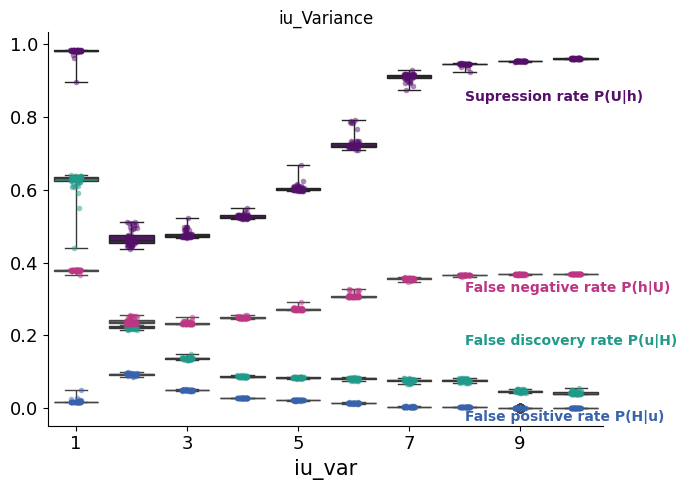

In [ ]:
plot_fp_fn(
    sym,
    title="iu_Variance",
    xlabel="iu_var",
    ylabel="",
    legend=True,
    legend_loc="upper right",
    save_path="figs",
)

## Data labeling
mu
mean-in
var-in
mean-iu
var-iu
mean-Fn-LEFT
var-Fn-LEFT
mean-Fn-RIGHT
var-Fn-RIGHT
mean-Fu-LEFT
var-Fu-LEFT
mean-Fu-RIGHT
var-Fu-RIGHT